In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler

train_df = pd.read_csv('../data/raw/train_FD001.txt', sep='\s+', header=None, engine='python')
train_df = train_df.iloc[:, :26]
columns = ['engine_id', 'cycle', 'op1', 'op2', 'op3'] + [f's{i}' for i in range(1, 22)]
train_df.columns = columns
print(train_df.head())

   engine_id  cycle     op1     op2    op3      s1      s2       s3       s4  \
0          1      1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60   
1          1      2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14   
2          1      3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20   
3          1      4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87   
4          1      5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22   

      s5  ...     s12      s13      s14     s15   s16  s17   s18    s19  \
0  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2  14.62  ...  522.42  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
3  14.62  ...  522.86  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
4  14.62  ...  522.19  2388.04  8133.80  8.4294  0.03  393  2388  100.0   

     s20      s21  
0  39.06  23.4190  
1  39.00  23.4236  
2  38.95

In [23]:
train_df['max_cycle'] = train_df.groupby('engine_id')['cycle'].transform('max')
train_df['rul'] = train_df['max_cycle'] - train_df['cycle']

In [24]:
print("Shape:", train_df.shape)
print("Columns:", train_df.columns.tolist())
print("Missing values sum:", train_df.isnull().sum().sum())
num_engines = train_df['engine_id'].nunique()
print("Number of unique engines:", num_engines)

Shape: (20631, 28)
Columns: ['engine_id', 'cycle', 'op1', 'op2', 'op3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 'max_cycle', 'rul']
Missing values sum: 0
Number of unique engines: 100


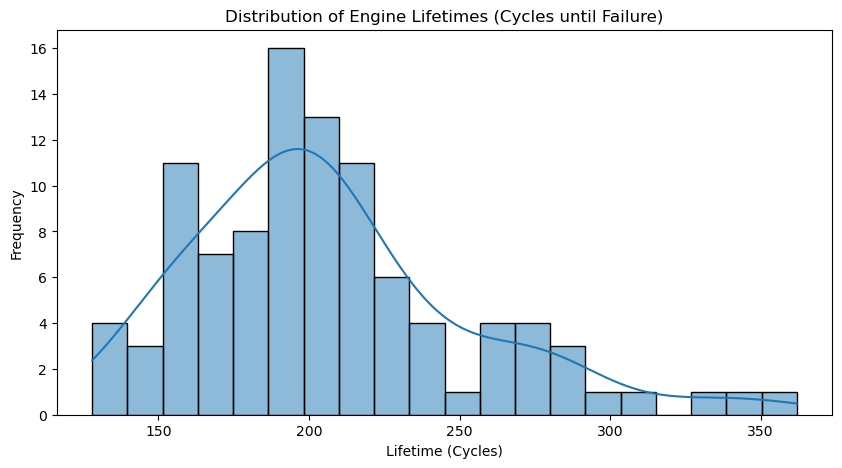

In [25]:
lifetimes = train_df.groupby('engine_id')['max_cycle'].max()
plt.figure(figsize=(10, 5))
sns.histplot(lifetimes, bins=20, kde=True)
plt.title('Distribution of Engine Lifetimes (Cycles until Failure)')
plt.xlabel('Lifetime (Cycles)')
plt.ylabel('Frequency')
plt.savefig('../results/figures/engine_lifetime_histogram.png')
plt.show()

In [26]:
print("Lifetime stats: Min={}, Max={}, Mean={:.2f}, Median={:.2f}".format(
    lifetimes.min(), lifetimes.max(), lifetimes.mean(), lifetimes.median()
))

Lifetime stats: Min=128, Max=362, Mean=206.31, Median=199.00


### Engine Lifetime Distribution Insight
The engines in FD001 fail between 128 and 362 cycles, with a mean lifetime of approximately 206 cycles and a median of 199 cycles.
The right-skewed distribution indicates variability in degradation rates across engines, suggesting that Remaining Useful Life prediction must account for engine-specific degradation behavior rather than relying on a fixed lifetime assumption.

In [27]:
sensor_cols = [f's{i}' for i in range(1, 22)]

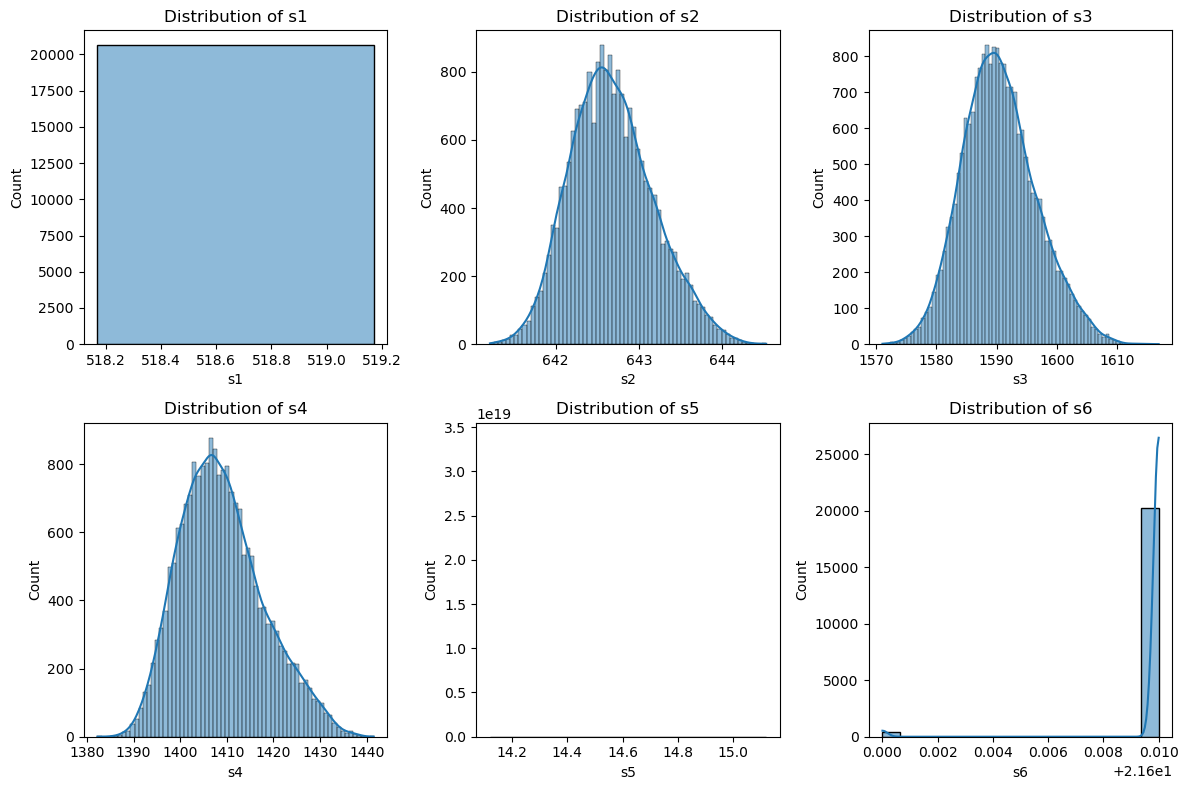

In [28]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(sensor_cols[:6]):
    plt.subplot(2, 3, i+1)
    sns.histplot(train_df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.savefig('../results/figures/sensor_distributions.png')
plt.show()

In [29]:
variances = train_df[sensor_cols].var()
low_var_sensors = variances[variances < 1e-4].index.tolist()
print("Low variance (constant/useless) sensors:", low_var_sensors)

Low variance (constant/useless) sensors: ['s1', 's5', 's6', 's10', 's16', 's18', 's19']


Several sensors (s1, s5, s6, s10, s16, s18, s19) exhibit near-zero variance across all engines and cycles.
These sensors provide no discriminatory information for degradation modeling and will be excluded from feature engineering to reduce noise and dimensionality.

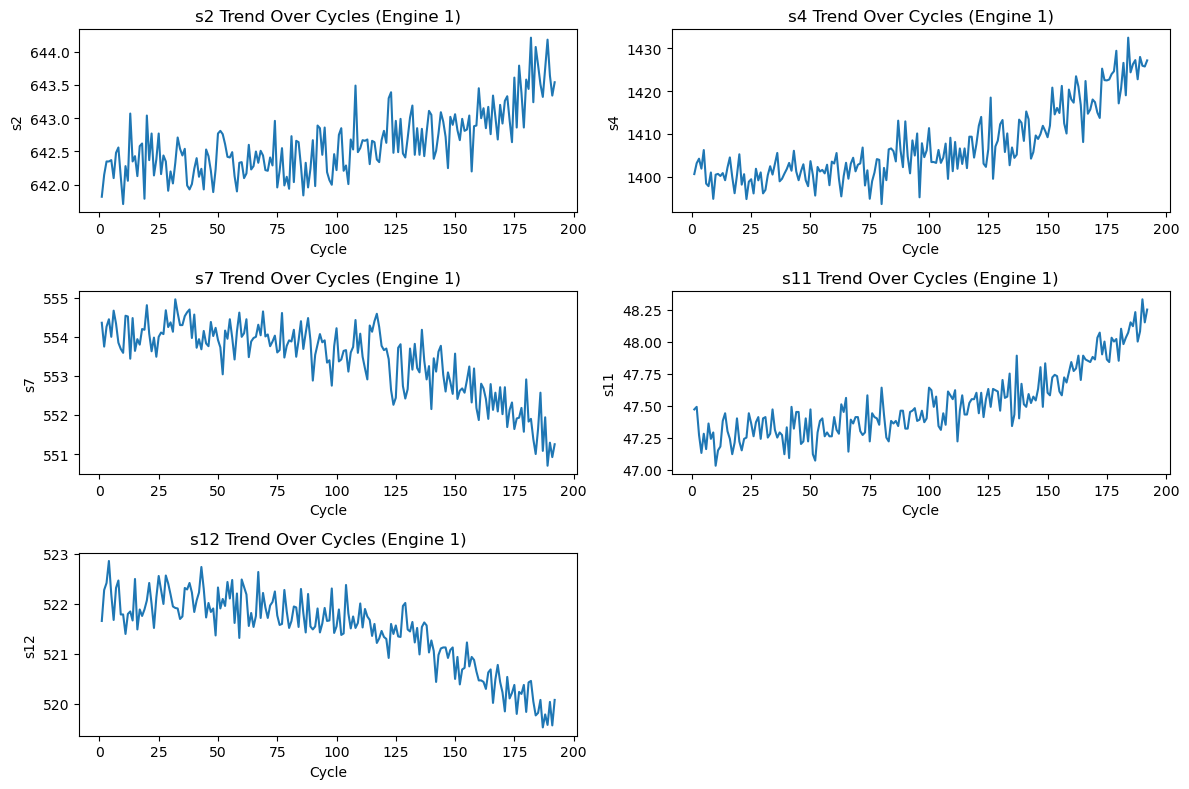

In [30]:
key_sensors = ['s2', 's4', 's7', 's11', 's12']  # Based on prelim corrs
plt.figure(figsize=(12, 8))
for i, sensor in enumerate(key_sensors):
    plt.subplot(3, 2, i+1)
    # Plot for a sample engine
    sample_engine = train_df[train_df['engine_id'] == 1]
    sns.lineplot(x=sample_engine['cycle'], y=sample_engine[sensor])
    plt.title(f'{sensor} Trend Over Cycles (Engine 1)')
    plt.xlabel('Cycle')
    plt.ylabel(sensor)
plt.tight_layout()
plt.savefig('../results/figures/sensor_trends_sample_engine.png')
plt.show()

Multiple sensors exhibit monotonic trends as failure approaches, indicating progressive degradation rather than random noise.
These sensors are strong candidates for temporal feature engineering (rolling means, slopes).

In [31]:
early_life = train_df[train_df['rul'] > train_df['rul'].quantile(0.9)]
late_life = train_df[train_df['rul'] < 10]
print("Early vs Late Life Sensor Means:")
for sensor in key_sensors:
    early_mean = early_life[sensor].mean()
    late_mean = late_life[sensor].mean()
    print(f"{sensor}: Early={early_mean:.2f}, Late={late_mean:.2f}")

Early vs Late Life Sensor Means:
s2: Early=642.33, Late=643.60
s4: Early=1401.67, Late=1427.39
s7: Early=554.05, Late=551.63
s11: Early=47.32, Late=48.10
s12: Early=522.00, Late=519.93


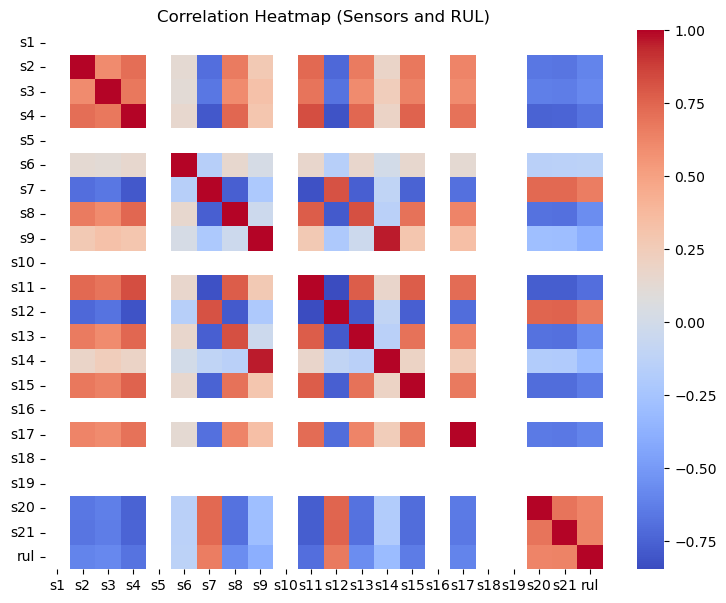

In [33]:
corr_matrix = train_df[sensor_cols + ['rul']].corr()
plt.figure(figsize=(9, 7))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap (Sensors and RUL)')
plt.savefig('../results/figures/correlation_heatmap.png')
plt.show()

In [34]:
corrs = corr_matrix['rul'].drop('rul').sort_values(ascending=False)
print("Correlations with RUL:\n", corrs)
strong_corrs = corrs[abs(corrs) > 0.5]
print("Strong correlations (|corr| > 0.5):", strong_corrs.to_dict())

Correlations with RUL:
 s12    0.671983
s7     0.657223
s21    0.635662
s20    0.629428
s6    -0.128348
s14   -0.306769
s9    -0.390102
s13   -0.562569
s8    -0.563968
s3    -0.584520
s17   -0.606154
s2    -0.606484
s15   -0.642667
s4    -0.678948
s11   -0.696228
s1          NaN
s5          NaN
s10         NaN
s16         NaN
s18         NaN
s19         NaN
Name: rul, dtype: float64
Strong correlations (|corr| > 0.5): {'s12': 0.6719831036133275, 's7': 0.6572226620546537, 's21': 0.6356620421802941, 's20': 0.6294284994377553, 's13': -0.5625688251670798, 's8': -0.5639684065755297, 's3': -0.5845203909176561, 's17': -0.6061535537829565, 's2': -0.6064839743785985, 's15': -0.6426670441974635, 's4': -0.6789482333860427, 's11': -0.6962281014553727}


Correlation analysis is used for feature screening; however, non-linear and temporal relationships will be captured during feature engineering and modeling.

In [35]:
op_cols = ['op1', 'op2', 'op3']

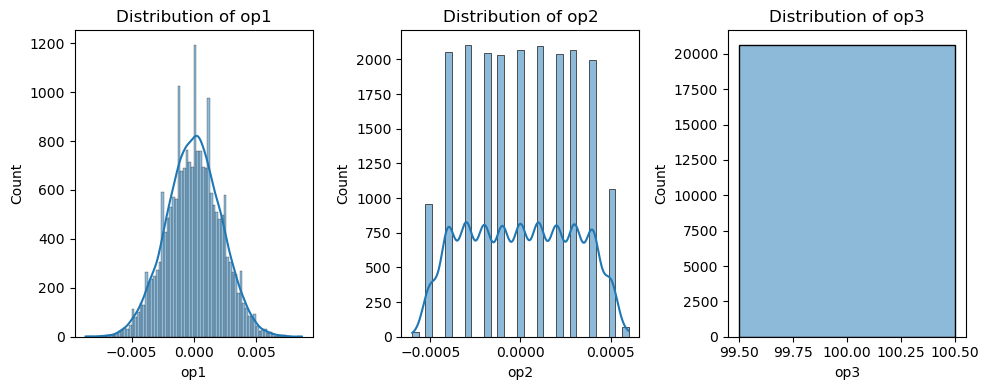

In [36]:
plt.figure(figsize=(10, 4))
for i, col in enumerate(op_cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(train_df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.savefig('../results/figures/op_distributions.png')
plt.show()

In [37]:
print("Unique values per op:", {col: train_df[col].nunique() for col in op_cols})

Unique values per op: {'op1': 158, 'op2': 13, 'op3': 1}


In [38]:
op_corrs = train_df[op_cols + ['rul']].corr()['rul'][op_cols]
print("Op correlations with RUL:", op_corrs.to_dict())

Op correlations with RUL: {'op1': -0.003198457554741038, 'op2': -0.0019476283515004475, 'op3': nan}


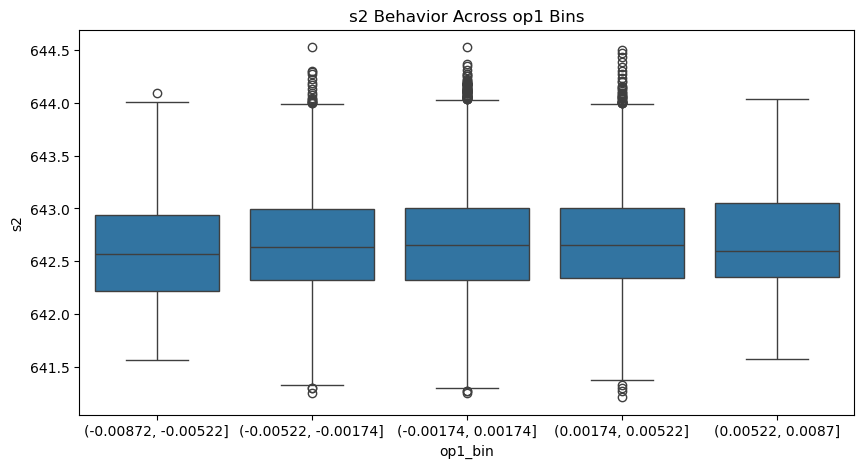

In [40]:
train_df['op1_bin'] = pd.cut(train_df['op1'], bins=5)
plt.figure(figsize=(10, 5))
sns.boxplot(x='op1_bin', y='s2', data=train_df)
plt.title('s2 Behavior Across op1 Bins')
plt.savefig('../results/figures/sensor_vs_op.png')
plt.show()

FD001 operates under a single dominant operating regime. Operational setting op3 is constant, while op1 and op2 vary within narrow ranges.

Correlation analysis shows no meaningful relationship between operational conditions and Remaining Useful Life. Additionally, sensor behavior remains consistent across operating-condition bins, indicating that degradation patterns are not confounded by operating regimes in this subset.

Therefore, operational conditions are retained as features but do not require regime-specific normalization or stratification.

In [41]:
train_df['cycles_to_failure'] = train_df['rul']  

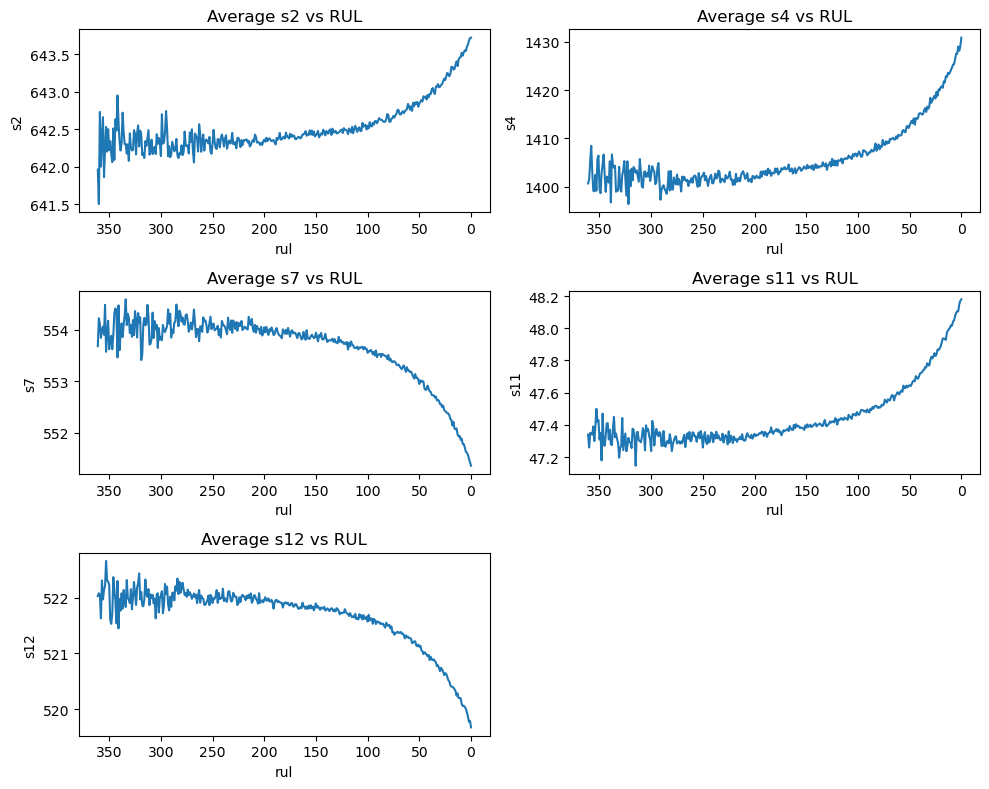

In [42]:
plt.figure(figsize=(10, 8))
for i, sensor in enumerate(key_sensors):
    plt.subplot(3, 2, i+1)
    sns.lineplot(x='rul', y=sensor, data=train_df.groupby('rul')[sensor].mean().reset_index())
    plt.title(f'Average {sensor} vs RUL')
    plt.gca().invert_xaxis()  
plt.tight_layout()
plt.savefig('../results/figures/sensor_vs_rul_avg.png')
plt.show()

Aggregated sensor behavior plotted against Remaining Useful Life reveals clear monotonic and nonlinear degradation trends. Sensor changes accelerate as RUL approaches zero, indicating that temporal and rolling features are necessary to capture degradation dynamics.

In [43]:
neg_corrs = corrs[corrs < 0].index.tolist()
pos_corrs = corrs[corrs > 0].index.tolist()
print("Monotonic increasing sensors (neg corr with RUL):", neg_corrs)
print("Monotonic decreasing sensors (pos corr with RUL):", pos_corrs)

Monotonic increasing sensors (neg corr with RUL): ['s6', 's14', 's9', 's13', 's8', 's3', 's17', 's2', 's15', 's4', 's11']
Monotonic decreasing sensors (pos corr with RUL): ['s12', 's7', 's21', 's20']


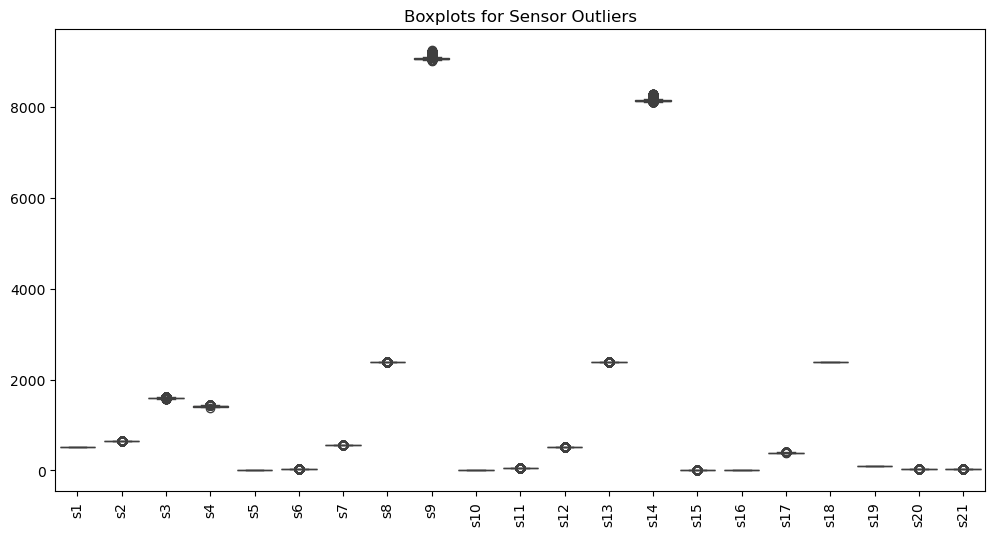

In [44]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df[sensor_cols])
plt.title('Boxplots for Sensor Outliers')
plt.xticks(rotation=90)
plt.savefig('../results/figures/sensor_boxplots.png')
plt.show()

In [46]:
z_scores = pd.DataFrame(
    zscore(train_df[sensor_cols]),
    columns=sensor_cols
)

outlier_counts = (np.abs(z_scores) > 3).sum()
print("Outliers per sensor (>3 z-score):", outlier_counts.to_dict())

Outliers per sensor (>3 z-score): {'s1': 0, 's2': 31, 's3': 47, 's4': 36, 's5': 0, 's6': 406, 's7': 34, 's8': 107, 's9': 521, 's10': 0, 's11': 23, 's12': 34, 's13': 83, 's14': 496, 's15': 33, 's16': 0, 's17': 81, 's18': 0, 's19': 0, 's20': 43, 's21': 34}


C:\Users\sarfras\AppData\Local\Temp\ipykernel_9252\3134198568.py:2: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  zscore(train_df[sensor_cols]),


Although some sensor readings fall beyond ±3 standard deviations, these values are consistent with late-stage degradation behavior rather than measurement noise. Therefore, no outlier removal is applied to preserve true failure dynamics.

*The exploratory analysis confirms that engine degradation in FD001 is primarily sensor-driven rather than operating-condition driven. Several sensors exhibit strong monotonic and nonlinear relationships with Remaining Useful Life, with degradation accelerating as failure approaches. Constant sensors were identified and removed, while outlier analysis suggests that extreme values represent true degradation rather than noise. These findings motivate the use of rolling and temporal features for Remaining Useful Life prediction.*

In [47]:
train_df.to_csv('../data/processed/train_with_rul.csv', index=False)